# Tests de différents modèles pour l'estimation de la survivabilité au cancer du sein

- **Autrice:** Emilia Beguin
- **Classe:** EPSI B3-DEVIA-DS
- **Date:** Novembre 2024
- **Intervenant:** Florian Pothin
- **Dataset:** [kaggle.com/.../breast-cancer](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer/data)

# Infos pour comprendre le dataframe et le diagnostique du cancer du sein

- **AGE**
  - Âge du patient au moment du diagnostic du cancer, en années.

- **RACE**
  - Description: Classification de la race en White, Black ou Other; indépendant de l'origine hispanique.
  - Codes :
    1. White
    2. Black
    3. Other (American Indian/AK Native, Asian/Pacific Islander)

- **MARITAL STATUS**
  - Description: État civil du patient au moment du diagnostic.
  - Codes :
    1. Single (Jamais marié)
    2. Married (incluent le *droit coutumier*)
    3. Separated
    4. Divorced
    5. Widowed

- **T STAGE**
  - Description: Stade T pour le cancer du sein, dérivé de données fusionnées.
  - Codes :
    1. T1
    2. T2
    3. T3
    4. T4

- **N STAGE**
  - Description: Stade N pour le cancer du sein, dérivé de données fusionnées.
  - Codes :
    1. N1
    2. N2
    3. N3

- **6TH STAGE**
  - Description: Stade du cancer du sein selon l'AJCC 6ème édition.
  - Codes :
    1. IIA
    2. IIB
    3. IIIA
    4. IIIB
    5. IIIC

- **GRADE**
  - Description: Grade et différenciation de la tumeur selon l'ICD-O-2 (1992).
  - Codes :
    1. Grade I (well differentiated)
    2. Grade II (moderately differentiated)
    3. Grade III (poorly differentiated)
    4. Grade IV (undifferentiated)
    5. Unspecified or unknown

- **A STAGE**
  - Description: Stade simplifié du cancer basé sur le Collaborative Stage (2004+) et l'Extent of Disease (1973-2003).
  - Codes :
    1. Regional
    2. Distant

- **TUMOR SIZE**
  - Description: Taille de la tumeur en millimètres, disponible depuis 2004.

- **ESTROGEN STATUS**
  - Description: Statut du récepteur des œstrogènes pour les cas de cancer du sein (1990+).
  - Codes :
    1. Positive
    2. Negative

- **PROGESTERONE STATUS**
  - Description: Statut du récepteur de la progestérone pour les cas de cancer du sein (1990+).
  - Codes :
    1. Positive
    2. Negative

- **REGIONAL NODES EXAMINED**
  - Description: Nombre total de ganglions lymphatiques régionaux retirés et examinés par le pathologiste.

- **REGIONAL NODES POSITIVE**
  - Description: Nombre exact de ganglions lymphatiques régionaux examinés contenant des métastases.

- **SURVIVAL MONTHS**
  - Description: Durée de survie en mois, calculée en utilisant les dates complètes.

- **STATUS**
  - Description: Statut vital à la date limite de l'étude.
  - Codes :
    1. Alive
    2. Dead

# Imports

In [357]:
# %pip install numpy==2.0.0
# %pip install pandas
# %pip install plotly
# %pip install lightgbm
# %pip install scikit-learn
# %pip install shap
# %pip install scipy

In [358]:
# STD
import random, collections, time

# DF
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from scipy.stats import chi2_contingency

# ML
import lightgbm
from lightgbm import LGBMClassifier

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import shap

In [359]:
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Sklearn version:", sklearn.__version__)
print("LightGBM version:", lightgbm.__version__)
print("SHAP version:", shap.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.3
Sklearn version: 1.5.2
LightGBM version: 4.5.0
SHAP version: 0.46.0


# Constantes

In [360]:
# Constantes à ne pas toucher :(
UNBALANCED = 0
BALANCED = 1
BOTH = 2
NONE = 3

In [361]:
# Constantes qu'on peut changer manuellement :)
SEED = 621
INITIAL_AGE_CATEGORY_TYPE = NONE # NONE, UNBALANCED, BALANCED ou BOTH
NB_BALANCED_GROUPS = 3 # Nombre de groupes pour la distribution d'age balancée (BALANCED)
IGNORE_GAUSSIAN_PROCESS = True # True pour ignorer le GAUSSIAN_PROCESS car très lent et bas dans le classement
SCALING = False
LIGHT_FEATURES = True

COLORS = ["#fbf8cc", "#fde4cf", "#ffcfd2", "#f1c0e8", "#cfbaf0", "#a3c4f3", "#90dbf4", "#8eecf5", "#98f5e1", "#b9fbc0"]

In [362]:
random.seed(SEED)
random.shuffle(COLORS)

# Infos sur le dataframe

https://ieee-dataport.org/open-access/seer-breast-cancer-data

![](./SEER%20Breast%20Cancer%20Data.png)

In [363]:
df_bc = pd.read_csv("data/breast_cancer.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_bc.head(2)

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive


In [364]:
df_bc.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


In [365]:
df_bc.describe(include=object)

,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Estrogen Status,Progesterone Status,Status
count,4024,4024,4024,4024,4024,4024,4024,4024,4024,4024,4024
unique,3,5,4,3,5,4,4,2,2,2,2
top,White,Married,T2,N1,IIA,Moderately differentiated,2,Regional,Positive,Positive,Alive
freq,3413,2643,1786,2732,1305,2351,2351,3932,3755,3326,3408


In [366]:
df_bc.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [367]:
def cramer_v(df):
    cramer_v_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            contingency_table = pd.crosstab(df[col1], df[col2])
            
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
            
            n = contingency_table.sum().sum()
            min_dim = min(contingency_table.shape) - 1
            cramer_v_value = np.sqrt(chi2_stat / (n * min_dim))
            
            cramer_v_matrix.loc[col1, col2] = cramer_v_value
    
    return cramer_v_matrix

# Calculer le V de Cramer
result = cramer_v(df_bc)
result


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
Age,1.0,0.130423,0.155738,0.104592,0.103537,0.100029,0.114453,0.114453,0.091982,0.167107,0.134337,0.126713,0.107512,0.096567,0.168199,0.146591
Race,0.130423,1.0,0.130927,0.032427,0.027485,0.033141,0.058882,0.058882,0.008734,0.156946,0.057726,0.035402,0.094134,0.092853,0.186167,0.083371
Marital Status,0.155738,0.130927,1.0,0.037659,0.052701,0.041788,0.039834,0.039834,0.043626,0.159606,0.043716,0.052395,0.138873,0.127058,0.174003,0.083808
T Stage,0.104592,0.032427,0.037659,1.0,0.200463,0.749645,0.086802,0.086802,0.380717,0.820468,0.069702,0.058579,0.142859,0.218714,0.182325,0.160358
N Stage,0.103537,0.027485,0.052701,0.200463,1.0,0.91152,0.119798,0.119798,0.297261,0.279846,0.102798,0.09569,0.300021,0.949181,0.220237,0.258998
6th Stage,0.100029,0.033141,0.041788,0.749645,0.91152,1.0,0.114418,0.114418,0.425689,0.538771,0.113682,0.102752,0.229663,0.623816,0.196658,0.26456
differentiate,0.114453,0.058882,0.039834,0.086802,0.119798,0.114418,1.0,1.0,0.051269,0.202995,0.232444,0.191652,0.135386,0.13643,0.18057,0.167246
Grade,0.114453,0.058882,0.039834,0.086802,0.119798,0.114418,1.0,1.0,0.051269,0.202995,0.232444,0.191652,0.135386,0.13643,0.18057,0.167246
A Stage,0.091982,0.008734,0.043626,0.380717,0.297261,0.425689,0.051269,0.051269,0.994438,0.308657,0.062242,0.024334,0.137113,0.278201,0.224465,0.094275
Tumor Size,0.167107,0.156946,0.159606,0.820468,0.279846,0.538771,0.202995,0.202995,0.308657,1.0,0.211626,0.206881,0.174375,0.187756,0.165834,0.218505


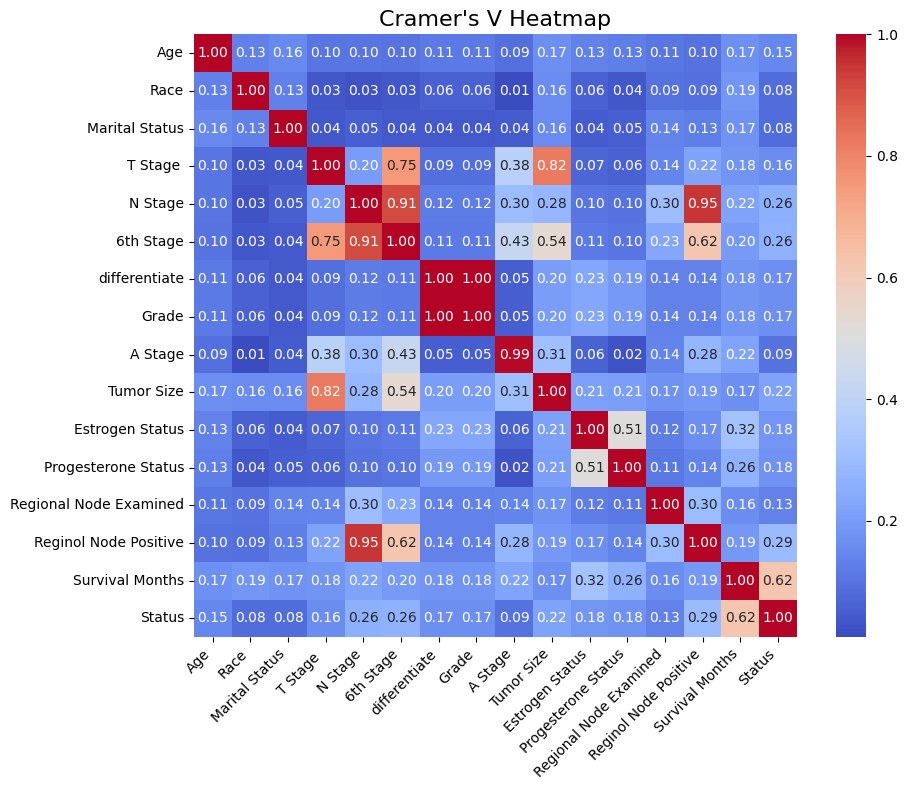

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(matrix, title="Cramer's V Heatmap"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix.astype(float),  # Convertir en float si nécessaire
        annot=True,            # Afficher les valeurs
        cmap="coolwarm",       # Palette de couleurs
        cbar=True,             # Barre de couleur
        square=True,           # Garder les cellules carrées
        fmt=".2f"              # Format des nombres
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

cramer_v_matrix = cramer_v(df_bc)

plot_heatmap(cramer_v_matrix)


# Nétoyage des données

## Tranches d'âge

### Tranches d'âge égales

In [369]:
bins = [29, 43, 56, 120]
cats = ["Group 1", "Group 2", "Group 3"]
df_bc["Age_cat"] = pd.cut(df_bc["Age"], bins, labels=cats)

### Tranches d'âge balanced

In [370]:
ageCount = collections.OrderedDict(sorted(df_bc["Age"].value_counts().to_dict().items()))
counts = tuple(ageCount.values())

total_count = np.sum(counts)
target_sum = total_count / NB_BALANCED_GROUPS

groups = []
current_group = []
current_sum = 0

for age2, count in ageCount.items():
    current_group.append((age2, count))
    current_sum += count
    
    if current_sum >= target_sum or (len(groups) == NB_BALANCED_GROUPS-1 and np.sum(counts[len(groups)*len(current_group):]) <= target_sum):
        groups.append(current_group)
        current_group = []
        current_sum = 0

if current_group:
    groups.append(current_group)

group_ages = [list(zip(*group))[0] for group in groups]
group_counts = [list(zip(*group))[1] for group in groups]
group_totals = [np.sum(counts) for counts in group_counts]

bins = []
for group in group_ages:
    bins.append(min(group)-1)
bins.append(group_ages[-1][-1])

for i, total in enumerate(group_totals):
    print(f"Group {bins[i]}-{bins[i+1]} -> {total} ppl")

labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins[0:-1]))]
df_bc["Age_cat_balanced"] = pd.cut(df_bc["Age"], bins, labels=labels)

Group 29-49 -> 1354 ppl
Group 49-59 -> 1390 ppl
Group 59-69 -> 1280 ppl


### Visualisation des tranches d'âge

In [371]:

age_counts = df_bc.groupby(['Age', 'Age_cat'], observed=False).size().reset_index(name='Count')

fig = px.bar(
    data_frame=age_counts,
    title="Age distribution",
    x="Age",
    y="Count",
    color="Age_cat",
    labels={"x": "Age", "y": "Count"},
    color_discrete_sequence=COLORS,
    template="plotly_dark",
)

fig.show()

age_counts_balanced = df_bc.groupby(['Age', 'Age_cat_balanced'], observed=False).size().reset_index(name='Count')

fig = px.bar(
    data_frame=age_counts_balanced,
    title="Age distribution in balanced groups",
    x="Age",
    y="Count",
    color="Age_cat_balanced",
    labels={"x": "Age", "y": "Count"},
    color_discrete_sequence=COLORS,
    template="plotly_dark",
)

fig.show()


In [372]:
if INITIAL_AGE_CATEGORY_TYPE != NONE:
    df_bc.drop("Age", inplace=True, axis=1)
if INITIAL_AGE_CATEGORY_TYPE == BALANCED or INITIAL_AGE_CATEGORY_TYPE == NONE:
    df_bc.drop("Age_cat", inplace=True, axis=1)
if INITIAL_AGE_CATEGORY_TYPE == UNBALANCED or INITIAL_AGE_CATEGORY_TYPE == NONE:
    df_bc.drop("Age_cat_balanced", inplace=True, axis=1)

## Ethnicité

In [373]:

fig = px.box(
    df_bc,
    x="Race",
    y="Tumor Size",
    color="Status",
    color_discrete_sequence=COLORS,
    template="plotly_dark")

fig.show()

In [374]:

if LIGHT_FEATURES:
    df_bc.drop("Race", inplace=True, axis=1)
else:
    df_bc = pd.get_dummies(df_bc, columns=["Race"], dtype=int)

## Status martial

In [375]:
fig = px.box(
    df_bc,
    x="Status",
    y="Tumor Size",
    color="Marital Status",
    color_discrete_sequence=COLORS,
    template="plotly_dark")

fig.show()

In [376]:
if LIGHT_FEATURES:
    df_bc.drop("Marital Status", inplace=True, axis=1)
else:
    df_bc = pd.get_dummies(df_bc, columns=["Marital Status"], dtype=int)

## Tumor size / T Stage

In [377]:
df_bc.rename(columns={"T Stage ": "T Stage"}, inplace=True)
px.box(
    df_bc,
    x="T Stage",
    y="Tumor Size",
    color_discrete_sequence=COLORS,
    template="plotly_dark")

In [378]:
# df_bc.drop("Tumor Size", inplace=True, axis=1)

## Oeustrogen et progesterone

In [379]:
df_bc["Estrogen Status"] = df_bc["Estrogen Status"].replace({"Negative": False, "Positive": True})

df_bc["Progesterone Status"] = df_bc["Progesterone Status"].replace({"Negative": False, "Positive": True})

C:\Users\emili\AppData\Local\Temp\ipykernel_12524\2697660093.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\emili\AppData\Local\Temp\ipykernel_12524\2697660093.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



## Stage T, N, A et "6th" + Grade

In [380]:
df_bc["T Stage"] = df_bc["T Stage"].replace({"T1": 1, "T2": 2, "T3": 3, "T4": 4}).infer_objects(copy=False)

df_bc["N Stage"] = df_bc["N Stage"].replace({"N1": 1, "N2": 2, "N3": 3})

df_bc.rename(columns={"A Stage": "Regional"}, inplace=True)
df_bc["Regional"] = df_bc["Regional"].replace({"Regional": 1, "Distant": 0})

df_bc["6th Stage"] = df_bc["6th Stage"].replace({"IIA": 1, "IIB": 2, "IIIA": 3, "IIIB": 4, "IIIC": 5})


# Grade
print("Avant:", list(df_bc["Grade"].value_counts().keys()))

df_bc["Grade"] = df_bc["Grade"].replace({" anaplastic; Grade IV": "4"})

df_bc["Grade"] = df_bc["Grade"].astype(str).astype(int)

print("Après:", list(df_bc["Grade"].value_counts().keys()))

Avant: ['2', '3', '1', ' anaplastic; Grade IV']
Après: [2, 3, 1, 4]


C:\Users\emili\AppData\Local\Temp\ipykernel_12524\515299347.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\emili\AppData\Local\Temp\ipykernel_12524\515299347.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\emili\AppData\Local\Temp\ipykernel_12524\515299347.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.

## Differentiate

In [381]:
df_bc.rename(columns={"differentiate": "Differentiate"}, inplace=True)
df_bc["Differentiate"] = df_bc["Differentiate"].replace({"Well differentiated": "1", "Moderately differentiated": "2", "Poorly differentiated": "3", "Undifferentiated": "4"})
df_bc["Differentiate"] = df_bc["Differentiate"].astype(int)
df_bc.rename(columns={"Differentiate": "differentiate"}, inplace=True)

In [382]:
fig = px.box(
    df_bc,
    x="differentiate",
    y="Grade",
    color_discrete_sequence=COLORS,
    template="plotly_dark")

fig.show()

In [383]:
# Drop car c'est exactement la meme chose
df_bc.drop("differentiate", inplace=True, axis=1)

## Status

In [384]:
df_bc["Status"] = df_bc["Status"].replace({"Alive": True, "Dead": False})
df_bc.rename(columns={"Status": "Alive"}, inplace=True)

C:\Users\emili\AppData\Local\Temp\ipykernel_12524\119790534.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



# Dernière vérification

In [385]:
description =df_bc.describe(include = 'all')
description.replace({np.nan: ""}, inplace=True)
description

,Age,T Stage,N Stage,6th Stage,Grade,Regional,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Alive
count,4024.0,4024.0,4024.0,4024.0,4024.0,4024.0,4024.0,4024,4024,4024.0,4024.0,4024.0,4024
unique,,,,,,,,2,2,,,,2
top,,,,,,,,True,True,,,,True
freq,,,,,,,,3755,3326,,,,3408
mean,53.972167,1.784791,1.43837,2.321819,2.150596,0.977137,30.473658,,,14.357107,4.158052,71.297962,
std,8.963134,0.765531,0.693479,1.266624,0.638234,0.149485,21.119696,,,8.099675,5.109331,22.92143,
min,30.0,1.0,1.0,1.0,1.0,0.0,1.0,,,1.0,1.0,1.0,
25%,47.0,1.0,1.0,1.0,2.0,1.0,16.0,,,9.0,1.0,56.0,
50%,54.0,2.0,1.0,2.0,2.0,1.0,25.0,,,14.0,2.0,73.0,
75%,61.0,2.0,2.0,3.0,3.0,1.0,38.0,,,19.0,5.0,90.0,


In [386]:
df_bc.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     4024 non-null   int64
 1   T Stage                 4024 non-null   int64
 2   N Stage                 4024 non-null   int64
 3   6th Stage               4024 non-null   int64
 4   Grade                   4024 non-null   int32
 5   Regional                4024 non-null   int64
 6   Tumor Size              4024 non-null   int64
 7   Estrogen Status         4024 non-null   bool 
 8   Progesterone Status     4024 non-null   bool 
 9   Regional Node Examined  4024 non-null   int64
 10  Reginol Node Positive   4024 non-null   int64
 11  Survival Months         4024 non-null   int64
 12  Alive                   4024 non-null   bool 
dtypes: bool(3), int32(1), int64(9)

# IT'S SCIKITLEARN TIME

Pour ce qui est de la classification, n'ayant pas une grande expérence, je ne savais pas quoi choisir. J'ai donc testé plusieurs models de scikit learn ainsi que LightGBM dont j'ai entendu parler lors d'une conférence au salon de la data 2024. L'image ci dessous montre différents models visuellement. Je ne pourrais pas montrer mes résultats visuellement comme ca mais je montrerai en conclusion l'accuracy, le recall, la precision, et le score F1.

J'ai testé pour l'instant:
- Random forest
- Gaussian Process
- Nearest Neighbors
- Linerar Discriminent Analysis
- LightGBM (boosting)

![scikit-learn classifiers](https://scikit-learn.org/1.5/_images/sphx_glr_plot_classifier_comparison_001.png)

In [387]:
X = df_bc.drop('Alive', axis=1)
y = df_bc['Alive']

In [388]:
df_res = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "Precision", "F1", "ROC", "Training duration"])
df_test = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "Precision", "F1", "ROC", "Training duration"])

def rnd_prcnt(x):
    return f"{round(x*100, 2)}%"

def rnd_sec(x):
    return f"{round(x, 3)} sec"

def add_results(df, model_name, y_test, y_pred, duration):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    df.loc[len(df)] = [model_name, rnd_prcnt(accuracy), rnd_prcnt(recall), rnd_prcnt(precision), rnd_prcnt(f1), rnd_prcnt(roc), rnd_sec(duration)]

In [389]:
def scale_features(X):
    scaler = StandardScaler()
    cols = X.columns
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=cols)

X = scale_features(X) if SCALING else X

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Random Forest

Ensemble d'arbres de décision. Chaque arbre est entraîné sur un sous-ensemble aléatoire des données et des caractéristiques, et la prédiction finale est obtenue par vote (classification) ou moyenne (régression). Avantages : robuste au surapprentissage et performant sur des données complexes.

In [391]:
rdf_params = {
    "random_state": SEED,
    "max_leaf_nodes": 330,
    "max_depth": 5,
    "n_estimators": 60, # moins que la valeur par defaut mais plus rapide et meilleur ROC
    "criterion": "gini",
    "max_features": "sqrt",
    "min_impurity_decrease": 0.00001
}

model_rdf = RandomForestClassifier(**rdf_params)
# model_rdf = RandomForestClassifier(random_state=SEED)
start = time.time()
model_rdf.fit(X_train, y_train)
stop = time.time()

Tweaker les paramètres du random forest a fait gagner 1% d'accuracy et réduit la durée du training par 2.

### Evaluation du model

In [392]:
y_pred_rdf = model_rdf.predict(X_test)
duration_rdf = stop - start

add_results(df_res, "Random Forest", y_test, y_pred_rdf, duration_rdf)

## Adaptive Boosting (AdaBoost)

Un modèle d'ensemble qui combine plusieurs "faibles apprenants" (souvent des arbres de décision simples) en pondérant les erreurs. Chaque itération se concentre sur les erreurs précédentes pour améliorer les performances. Idéal pour des données bien préparées.

In [393]:


model_svc = AdaBoostClassifier(random_state=SEED)
start = time.time()
model_svc.fit(X_train, y_train)
stop = time.time()

c:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



### Evaluation du model

In [394]:
y_pred_svc = model_svc.predict(X_test)
duration_svc = stop - start

add_results(df_res, "AdaBoost", y_test, y_pred_svc, duration_svc)

add_results(df_test, "AdaBoost test", y_test, y_pred_svc, duration_svc)
df_test

,Model,Accuracy,Recall,Precision,F1,ROC,Training duration
0,AdaBoost test,88.57%,96.88%,90.17%,93.4%,71.75%,0.119 sec


## Gaussian Process

Un modèle bayésien qui prédit des valeurs continues avec une estimation des incertitudes. Basé sur des distributions normales et utilisé principalement pour des problèmes de régression avec des données petites à moyennes.

In [395]:
if not IGNORE_GAUSSIAN_PROCESS:
    model_gp = GaussianProcessClassifier(random_state=SEED)
    start = time.time()
    model_gp.fit(X_train, y_train)
    stop = time.time()


### Evaluation du model

In [396]:
if not IGNORE_GAUSSIAN_PROCESS:
    y_pred_gp = model_gp.predict(X_test)
    duration_gp = stop - start

    add_results(df_res, "Gaussian Process", y_test, y_pred_gp, duration_gp)

## Nearest Neighbors

Un algorithme simple qui classe ou prédit en fonction des voisins les plus proches dans les données. Utilise une distance (par ex., Euclidienne) pour comparer les points. Avantages : facile à comprendre, mais lent pour de grandes données.

In [397]:
model_knc = KNeighborsClassifier()
start = time.time()
model_knc.fit(X_train, y_train)
stop = time.time()

### Evaluation du model

In [398]:
y_pred_knc = model_knc.predict(X_test)
duration_knc = stop - start

add_results(df_res, "Nearest Neighbors", y_test, y_pred_knc, duration_knc)

## Linear Discriminant Analysis (LDA)

Un modèle linéaire qui trouve une combinaison des caractéristiques pour maximiser la séparation entre les classes. Souvent utilisé pour la classification avec des données bien séparées.

In [399]:
model_lda = LinearDiscriminantAnalysis()
start = time.time()
model_lda.fit(X_train, y_train)
stop = time.time()

### Evaluation du model

In [400]:
y_pred_lda = model_lda.predict(X_test)
duration_lda = stop - start

add_results(df_res, "Linear Discriminant Analysis", y_test, y_pred_lda, duration_lda)

## Support Vector Classifier (SVC)

Une méthode qui trouve l'hyperplan optimal pour séparer les classes dans un espace à haute dimension. Peut utiliser des "kernels" pour s'adapter à des frontières complexes. Efficace pour des problèmes de classification binaire.

In [401]:

model_svc = svm.SVC(random_state=SEED, probability=True)
start = time.time()
model_svc.fit(X_train, y_train)
stop = time.time()

Tweaker les paramètres du random forest a fait gagner 1% d'accuracy et réduit la durée du training par 2.

### Evaluation du model

In [402]:
y_pred_svc = model_svc.predict(X_test)
duration_svc = stop - start

add_results(df_res, "SVC", y_test, y_pred_svc, duration_svc)

## LightGBM

Un modèle de boosting basé sur des arbres de décision, optimisé pour les grandes données et les hautes dimensions. Très rapide et performant, il utilise des techniques comme le "leaf-wise growth" pour améliorer les prédictions.

In [403]:
model_lgbm = LGBMClassifier(random_state=SEED)
start = time.time()
model_lgbm.fit(X_train, y_train)
stop = time.time()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2736, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 3219, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.849953 -> initscore=1.734236
[LightGBM] [Info] Start training from score 1.734236


### Evaluation du model

In [404]:
y_pred_lgbm = model_lgbm.predict(X_test)
duration_lgbm = stop - start

add_results(df_res, "LightGBM", y_test, y_pred_lgbm, duration_lgbm)

### Feature importance

In [405]:

feature_importance = model_lgbm.feature_importances_
feature_names = X.columns
    
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

feature_importance_df.sort_values(by="Importance", ascending=False, ignore_index=True)

,Feature,Importance
0,Survival Months,711
1,Tumor Size,538
2,Age,535
3,Regional Node Examined,503
4,Reginol Node Positive,320
5,Grade,134
6,6th Stage,75
7,Progesterone Status,59
8,T Stage,47
9,N Stage,47


### SHAP (pour le modèle LightGBM)

c:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



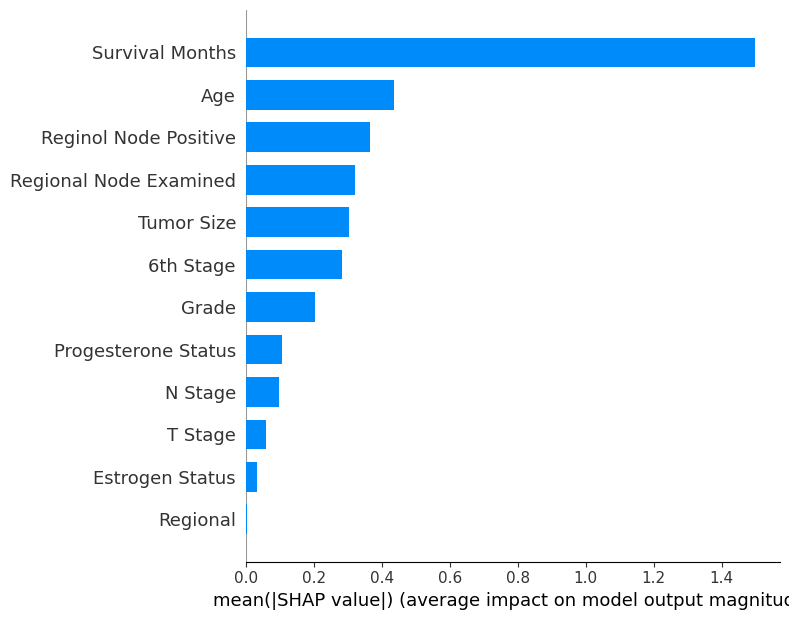

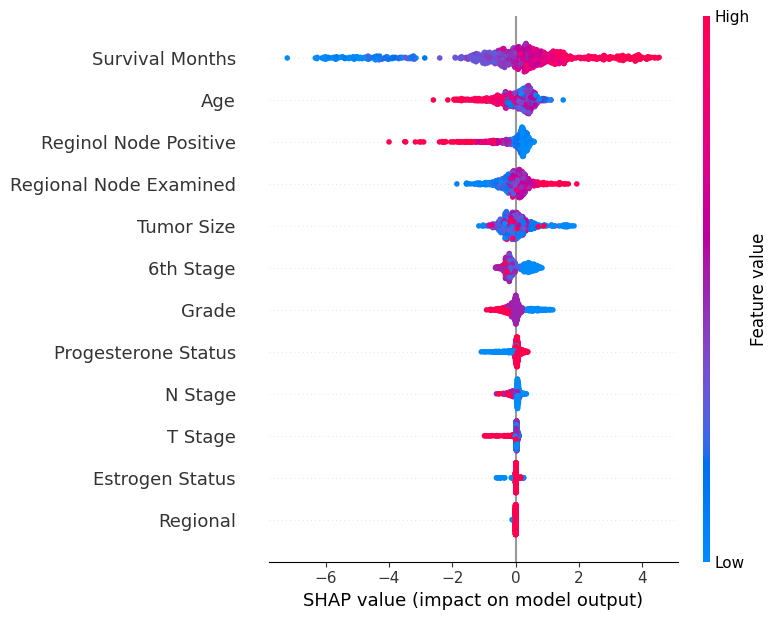

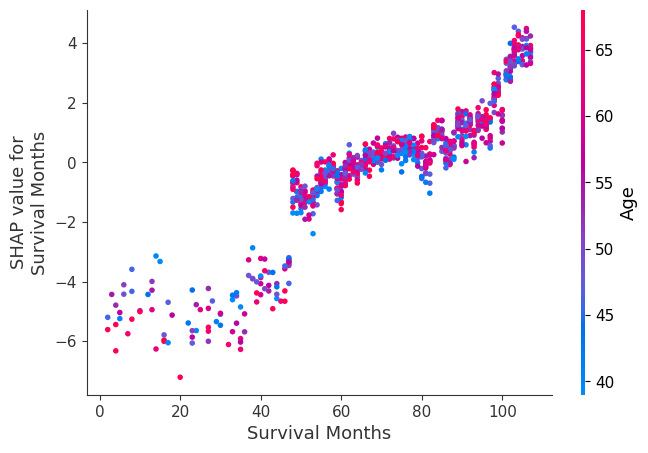

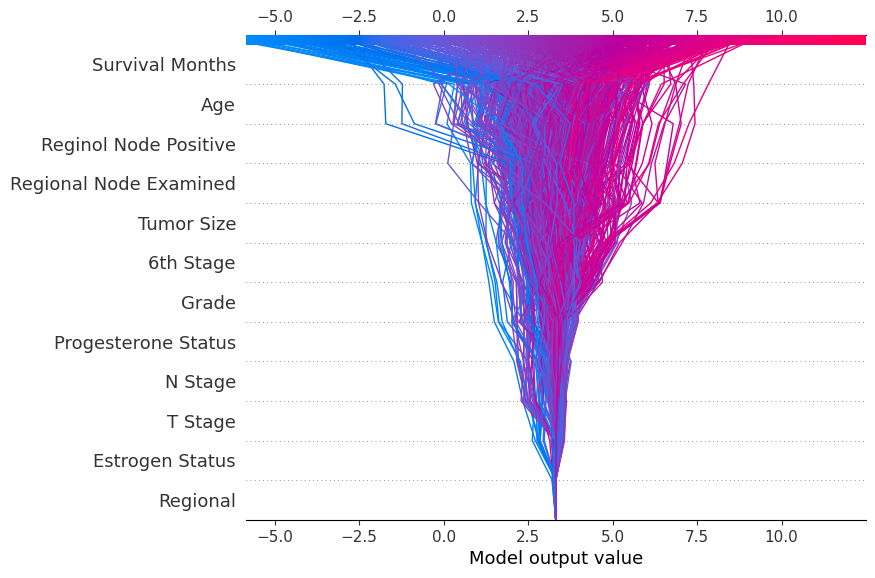

In [406]:
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
# shap.plots.violin(shap_values, feature_names=feature_names)
shap.dependence_plot("Survival Months", shap_values, X_test, interaction_index="Age")
shap.decision_plot(explainer.expected_value, shap_values, X_test.columns)

# Conclusion

## Matrices de confusion (random forest)

In [407]:
df_confusion_matrix = pd.crosstab(y_test, y_pred_svc, rownames=['Actuel'], colnames=['Prédit'])
df_confusion_matrix

Prédit,False,True
Actuel,,
False,43,90
True,15,657


## Tableau des résultats

In [408]:
df_res

,Model,Accuracy,Recall,Precision,F1,ROC,Training duration
0,Random Forest,89.07%,98.36%,89.57%,93.76%,70.23%,0.109 sec
1,AdaBoost,88.57%,96.88%,90.17%,93.4%,71.75%,0.119 sec
2,Nearest Neighbors,86.58%,95.98%,88.84%,92.27%,67.54%,0.031 sec
3,Linear Discriminant Analysis,87.2%,96.43%,89.13%,92.64%,68.52%,0.04 sec
4,SVC,86.96%,97.77%,87.95%,92.6%,65.05%,0.418 sec
5,LightGBM,88.07%,96.28%,90.11%,93.09%,71.45%,0.243 sec


# Export du model (random forest)

In [409]:

if False:
    import joblib

    joblib.dump(model_rdf, "models/model_rdf.joblib")

# Mini app avec ipywidgets pour tester les modeles

In [410]:
import ipywidgets as widgets

In [411]:
style = {'description_width': 'initial'}

model_id = widgets.Dropdown(description="Model", options=[("Random Forest", 0), ("AdaBoost", 1), ("Nearest Neighbors", 2), ("Linear Discriminant Analysis", 3), ("SVC", 4), ("LightGBM", 5)])
age = widgets.BoundedIntText(description='Age', value=45, min=1, max=150)
tstage = widgets.Dropdown(description="T stage", options=[('T1', 1), ("T2", 2), ("T3", 3), ("T4", 4)], value=1)
nstage = widgets.Dropdown(description="N stage", options=[('N1', 1), ("N2", 2), ("N3", 3)], value=1)
sixthstage = widgets.Dropdown(description="6th stage", options=[('IIA', 1), ("IIB", 2), ("IIIA", 3), ("IIIB", 4), ("IIIC", 5)], value=1)
grade = widgets.Dropdown(description="Grade", options=[('Grade I (well differentiated)', 1), ("Grade II (moderately differentiated)", 2), ("Grade III (poorly differentiated)", 3), ("Grade IV (undifferentiated)", 4)], value=1)
astage = widgets.Dropdown(description="A stage", options=[('Regional', 1), ("Distant", 0)], value=1)
tumorsize = widgets.BoundedIntText(description="Tumor Size", value=27, min=1, max=200)
estro = widgets.Checkbox(description="Estrogen", value=True)
proge = widgets.Checkbox(description="Progesterone", value=True)
nodeexamined = widgets.IntSlider(description="Node examined", value=1, min=1, max=80, style=style)
nodepositive = widgets.IntSlider(description="Node positive", value=1, min=1, max=80, style=style)
months = widgets.IntSlider(description="Survival Months", value=1, min=1, max=150, style=style)

all_widgets = [model_id, age, tstage, nstage, sixthstage, grade, astage, tumorsize, estro, proge, nodeexamined, nodepositive, months]

# title = widgets.HTML(value="<h1>A</h1>")
text = widgets.Text(disabled=True, description="Le patient va il survivre ?", style=style)
raw = widgets.Text(disabled=True, description="Raw")

def compute(*ignore):
    all_values = [age.value, tstage.value, nstage.value, sixthstage.value, grade.value, astage.value, tumorsize.value, estro.value, proge.value, nodeexamined.value, nodepositive.value, months.value]
    model = [model_rdf, model_svc, model_knc, model_knc, model_svc, model_lgbm][model_id.value]
    prediction = model.predict_proba([all_values])
    text.value = "OUI (sûr à " + rnd_prcnt(prediction[0][1]) + ")" if prediction[0][1]>0.5 else "NON (sûr à " + rnd_prcnt(prediction[0][0]) + ")"

    raw.value = str(prediction)

for w in all_widgets:
    w.observe(compute, names='value')

# widgets.VBox([title]+all_widgets+[text, raw])
widgets.VBox(all_widgets+[text, raw])